#1 - Nettoyage et Analyse descriptive des données

*  **Source du jeu de données** : https://ressources.data.sncf.com/explore/dataset/tarifs-tgv-inoui-ouigo/table/
*   **Producteur du jeu de données** : SNCF Voyageurs
*   **Date de l'export** : 16/09/2024


In [480]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, shape
import pandas as pd


df = pd.read_csv("tarifs-tgv-inoui-ouigo.csv", sep=";")

df.head()

,Transporteur,Gare origine,Gare origine - code UIC,Gare destination,Gare destination - code UIC,Classe,Profil tarifaire,Prix minimum,Prix maximum
0,TGV INOUI,METZ VILLE,87192039,PARIS NORD,87271007,1,Tarif Réglementé,118.8,118.8
1,TGV INOUI,LAVAL,87478404,LYON PART DIEU,87723197,2,Tarif Normal,25.0,116.0
2,TGV INOUI,METZ VILLE,87192039,TOUL,87141044,1,Tarif Normal,7.0,25.0
3,TGV INOUI,MORLAIX,87474338,ST BRIEUC,87473009,2,Tarif Réglementé,16.2,21.3
4,TGV INOUI,ANGERS ST LAUD,87484006,AVIGNON CENTRE,87765008,1,Tarif Elève - Etudiant - Apprenti,24.0,24.0


In [481]:
print(df.shape)
print(df.dtypes)

(34135, 9)
Transporteur                    object
Gare origine                    object
Gare origine - code UIC          int64
Gare destination                object
Gare destination - code UIC      int64
Classe                           int64
Profil tarifaire                object
Prix minimum                   float64
Prix maximum                   float64
dtype: object


**1.1 Nettoyage des données**

In [482]:
missing_values = df.isnull().sum()
print(missing_values)

doublons = df[df.duplicated()]
print(f"Nombre de doublons : {doublons.shape[0]}")

def verify_and_correct_data_formats(df):
    expected_formats = {
        'Transporteur': 'object',
        'Gare origine': 'object',
        'Gare origine - code UIC': 'int64',
        'Gare destination': 'object',
        'Gare destination - code UIC': 'int64',
        'Classe': 'int64',
        'Profil tarifaire': 'object',
        'Prix minimum': 'float64',
        'Prix maximum': 'float64'
    }

    for column, expected_type in expected_formats.items():
        actual_type = df[column].dtype

        if actual_type != expected_type:
            print(f"Problème de format dans la colonne '{column}': attendu {expected_type}, trouvé {actual_type}")

            try:
                df[column] = df[column].astype(expected_type)
                print(f"Format de la colonne '{column}' corrigé avec succès.")
            except Exception as e:
                print(f"Erreur lors de la conversion de la colonne '{column}': {e}")
        else:
            print(f"Format de la colonne '{column}' est correct.")

    return df

df_corrected = verify_and_correct_data_formats(df)
print(df_corrected.head())

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers = detect_outliers(df, 'Prix minimum')
print(outliers)

Transporteur                   0
Gare origine                   0
Gare origine - code UIC        0
Gare destination               0
Gare destination - code UIC    0
Classe                         0
Profil tarifaire               0
Prix minimum                   0
Prix maximum                   0
dtype: int64
Nombre de doublons : 0
Format de la colonne 'Transporteur' est correct.
Format de la colonne 'Gare origine' est correct.
Format de la colonne 'Gare origine - code UIC' est correct.
Format de la colonne 'Gare destination' est correct.
Format de la colonne 'Gare destination - code UIC' est correct.
Format de la colonne 'Classe' est correct.
Format de la colonne 'Profil tarifaire' est correct.
Format de la colonne 'Prix minimum' est correct.
Format de la colonne 'Prix maximum' est correct.
  Transporteur    Gare origine  Gare origine - code UIC Gare destination  \
0    TGV INOUI      METZ VILLE                 87192039       PARIS NORD   
1    TGV INOUI           LAVAL                

**1.2 Analyse descriptive des données**

In [483]:
description_numerique = df.describe()
description_categorielle = df.describe(include=['object'])
print(f"Analyse descriptive des variables :\n{description_numerique}\n\n{description_categorielle}")

Analyse descriptive des variables :
       Gare origine - code UIC  Gare destination - code UIC        Classe  \
count             3.413500e+04                 3.413500e+04  34135.000000   
mean              8.751451e+07                 8.755030e+07      1.510502   
std               2.081035e+05                 2.053142e+05      0.499897   
min               8.711185e+07                 8.711185e+07      1.000000   
25%               8.731901e+07                 8.739100e+07      1.000000   
50%               8.748523e+07                 8.758385e+07      2.000000   
75%               8.772569e+07                 8.774232e+07      2.000000   
max               8.778401e+07                 8.778401e+07      2.000000   

       Prix minimum  Prix maximum  
count  34135.000000  34135.000000  
mean      36.513751     76.015360  
std       42.033001     58.328725  
min        0.000000      0.000000  
25%       14.000000     21.000000  
50%       21.000000     64.000000  
75%       31.00000

**Composition du dataset :**

Ce dataset met en valeur une fourchette de prix (prix min., prix max.) en fonction des trajets (gares de départs, gares d’arrivée) et des profils tarifaires (normal, étudiant, réglementé) et les classes tarifaires (1 ou 2).

*Les colonnes :*

**7 variables catégorielles** :
* Transporteur : Nominal
* Gare origine : Nominal
* Gare origine - code UIC => Clé primaire/Étrangère lien autre table
* Destination : Nominal
* Gare destination - code UIC => Clé primaire/Étrangère lien autre table
* Classe : ordinal
* Profil tarifaire : ordinal

**2 variables numériques :**

* Prix minimum : Continu
* Prix maximum : Continu

# 2 - Augmentation des données : Kilométrage
- **Source du jeu de données :** [Portail Open Data SNCF](https://ressources.data.sncf.com/explore/dataset/tarifs-tgv-inoui-ouigo/information/)
- **Producteur du jeu de données :** SNCF Voyageurs
- **Date de l'export :** 18 septembre 2024

In [484]:
import plotly.graph_objects as go
import plotly.express as px

df_base = pd.read_csv("https://raw.githubusercontent.com/mandresyandri/d2sn-dataSprint-2024/refs/heads/main/datasets/tarifs-tgv-inoui-ouigo.csv", sep=";")
df_km = pd.read_csv("https://raw.githubusercontent.com/dounia-pihan/sncf-low-fares-2024/refs/heads/main/Datasets/emission-co2-tgv.csv", sep=";")

df_km.head()

,Transporteur,Origine,Origine_uic,Destination,Destination_uic,Distance entre les gares,Train - Empreinte carbone (kgCO2e),Autocar longue distance - Empreinte carbone (kgCO2e),Avion - Empreinte carbone (kgCO2e),"Voiture électrique (2,2 pers.) - Empreinte carbone (kgCO2e)","Voiture thermique (2,2 pers.) - Empreinte carbone (kgCO2e)"
0,TGV,Paris Montparnasse,87391003,Rennes,87471003,364,1.3,10.5,79.8,16.5,37.8
1,TGV,Paris Montparnasse,87391003,Angers-St-Laud,87484006,303,1.1,9.0,68.4,14.1,32.5
2,TGV,Paris Montparnasse,87391003,Saint-Pierre-des-Corps,87571240,221,0.8,7.2,52.5,11.2,25.8
3,TGV,Paris Est,87113001,Strasbourg,87212027,451,1.6,14.6,104.0,22.9,52.7
4,TGV,Paris Est,87113001,Metz,87192039,352,1.2,10.0,73.6,15.6,35.9


In [485]:
df_km.columns

Index(['Transporteur ', 'Origine', 'Origine_uic', 'Destination ',
       'Destination_uic ', 'Distance entre les gares',
       'Train - Empreinte carbone (kgCO2e) ',
       'Autocar longue distance - Empreinte carbone (kgCO2e)',
       'Avion - Empreinte carbone (kgCO2e)',
       'Voiture électrique (2,2 pers.) - Empreinte carbone (kgCO2e)',
       'Voiture thermique (2,2 pers.) - Empreinte carbone (kgCO2e)'],
      dtype='object')

In [486]:
df_base.columns

Index(['Transporteur', 'Gare origine', 'Gare origine - code UIC',
       'Destination', 'Gare destination - code UIC', 'Classe',
       'Profil tarifaire', 'Prix minimum', 'Prix maximum'],
      dtype='object')

**2.1. Préparation au merge/concat**

In [487]:
df_km = df_km[['Transporteur ', 'Origine', 'Origine_uic', 'Destination ',
       'Destination_uic ', 'Distance entre les gares', ]]

df_km['Origine_uic'] = df_km['Origine_uic'].astype("str")
df_km['Destination_uic '] = df_km['Destination_uic '].astype("str")
df_km["concat_uic"] = df_km['Origine_uic']+ df_km['Destination_uic ']

df_km.head()

,Transporteur,Origine,Origine_uic,Destination,Destination_uic,Distance entre les gares,concat_uic
0,TGV,Paris Montparnasse,87391003,Rennes,87471003,364,8739100387471003
1,TGV,Paris Montparnasse,87391003,Angers-St-Laud,87484006,303,8739100387484006
2,TGV,Paris Montparnasse,87391003,Saint-Pierre-des-Corps,87571240,221,8739100387571240
3,TGV,Paris Est,87113001,Strasbourg,87212027,451,8711300187212027
4,TGV,Paris Est,87113001,Metz,87192039,352,8711300187192039


In [488]:
df_base = df_base[['Gare origine', 'Gare origine - code UIC', 'Destination', 'Gare destination - code UIC', 'Prix minimum', 'Prix maximum']]
df_base['Gare destination - code UIC'] = df_base['Gare destination - code UIC'].astype("str")
df_base['Gare origine - code UIC'] = df_base['Gare origine - code UIC'].astype("str")
df_base["concat_uic"] = df_base['Gare destination - code UIC'] + df_base['Gare origine - code UIC']

df_base.head()

,Gare origine,Gare origine - code UIC,Destination,Gare destination - code UIC,Prix minimum,Prix maximum,concat_uic
0,AEROPORT CDG2 TGV ROISSY,87271494,MARSEILLE ST CHARLES,87751008,16.0,99.0,8775100887271494
1,AEROPORT CDG2 TGV ROISSY,87271494,MONTPELLIER SUD DE FRANCE,87688887,16.0,99.0,8768888787271494
2,AIX EN PROVENCE TGV,87319012,LYON-SAINT EXUPERY TGV,87762906,10.0,69.0,8776290687319012
3,MARNE LA VALLEE CHESSY,87111849,AIX EN PROVENCE TGV,87319012,16.0,99.0,8731901287111849
4,MARNE LA VALLEE CHESSY,87111849,POITIERS,87575001,10.0,79.0,8757500187111849


In [489]:
print(df_km["concat_uic"].nunique())
print(df_base["concat_uic"].nunique())

118
4211


In [490]:
print(df_km.columns)
print(df_base.columns)

Index(['Transporteur ', 'Origine', 'Origine_uic', 'Destination ',
       'Destination_uic ', 'Distance entre les gares', 'concat_uic'],
      dtype='object')
Index(['Gare origine', 'Gare origine - code UIC', 'Destination',
       'Gare destination - code UIC', 'Prix minimum', 'Prix maximum',
       'concat_uic'],
      dtype='object')


In [491]:
df_km['concat_uic'].isin(df_base['concat_uic']).count()

np.int64(119)

**2.2. Fusion des données**

In [492]:
merged_df = df_base.merge(
    df_km[['concat_uic', 'Distance entre les gares']],
    on='concat_uic',
    how='left',
    indicator=True
    )
df_base['Distance entre les gares'] = np.where(
    merged_df['_merge'] == 'both',
    merged_df['Distance entre les gares'], np.nan
)

In [493]:
df_base.head()

,Gare origine,Gare origine - code UIC,Destination,Gare destination - code UIC,Prix minimum,Prix maximum,concat_uic,Distance entre les gares
0,AEROPORT CDG2 TGV ROISSY,87271494,MARSEILLE ST CHARLES,87751008,16.0,99.0,8775100887271494,NaN
1,AEROPORT CDG2 TGV ROISSY,87271494,MONTPELLIER SUD DE FRANCE,87688887,16.0,99.0,8768888787271494,NaN
2,AIX EN PROVENCE TGV,87319012,LYON-SAINT EXUPERY TGV,87762906,10.0,69.0,8776290687319012,NaN
3,MARNE LA VALLEE CHESSY,87111849,AIX EN PROVENCE TGV,87319012,16.0,99.0,8731901287111849,NaN
4,MARNE LA VALLEE CHESSY,87111849,POITIERS,87575001,10.0,79.0,8757500187111849,NaN


In [494]:
df_base[df_base['Distance entre les gares'].notnull()].head()

,Gare origine,Gare origine - code UIC,Destination,Gare destination - code UIC,Prix minimum,Prix maximum,concat_uic,Distance entre les gares
62,AIX EN PROVENCE TGV,87319012,MARNE LA VALLEE CHESSY,87111849,98.8,120.0,8711184987319012,720.0
105,METZ VILLE,87192039,PARIS EST,87113001,64.4,80.0,8711300187192039,352.0
107,MULHOUSE VILLE,87182063,PARIS EST,87113001,24.0,182.0,8711300187182063,495.0
113,METZ VILLE,87192039,PARIS EST,87113001,24.0,123.0,8711300187192039,352.0
300,STRASBOURG,87212027,PARIS EST,87113001,88.4,111.0,8711300187212027,451.0


In [495]:
df_base['Distance entre les gares'].isna().sum()

np.int64(15347)

**2.3. Calcul du prix par km**

In [496]:
df_base['r_concat_iuc'] = df_base['Gare destination - code UIC'] + df_base['Gare origine - code UIC']
df_km['r_concat_iuc'] = df_km['Origine_uic'] + df_km['Destination_uic ']

In [497]:
df_km.head()

,Transporteur,Origine,Origine_uic,Destination,Destination_uic,Distance entre les gares,concat_uic,r_concat_iuc
0,TGV,Paris Montparnasse,87391003,Rennes,87471003,364,8739100387471003,8739100387471003
1,TGV,Paris Montparnasse,87391003,Angers-St-Laud,87484006,303,8739100387484006,8739100387484006
2,TGV,Paris Montparnasse,87391003,Saint-Pierre-des-Corps,87571240,221,8739100387571240,8739100387571240
3,TGV,Paris Est,87113001,Strasbourg,87212027,451,8711300187212027,8711300187212027
4,TGV,Paris Est,87113001,Metz,87192039,352,8711300187192039,8711300187192039


In [498]:
merged_df = df_base.merge(
    df_km[['r_concat_iuc', 'Distance entre les gares']],
    on='r_concat_iuc',
    how='left',
    indicator=True
    )
df_base['Distance entre les gares'] = np.where(
    merged_df['_merge'] == 'both',
    merged_df['Distance entre les gares_y'],
    df_base['Distance entre les gares']
)
df_base['Distance entre les gares'] = df_base['Distance entre les gares'].interpolate(method='linear', limit_direction='both')

In [499]:
df_base['Prix par km'] = np.where(
    df_base['Distance entre les gares'].notnull(),
    df_base['Prix maximum'] / df_base['Distance entre les gares'],
    np.nan
)

for col in ['Prix minimum', 'Prix maximum', 'Distance entre les gares']:
    df_base[col] = pd.to_numeric(df_base[col], errors='coerce')

df_base.head()

,Gare origine,Gare origine - code UIC,Destination,Gare destination - code UIC,Prix minimum,Prix maximum,concat_uic,Distance entre les gares,r_concat_iuc,Prix par km
0,AEROPORT CDG2 TGV ROISSY,87271494,MARSEILLE ST CHARLES,87751008,16.0,99.0,8775100887271494,720.0,8775100887271494,0.137500
1,AEROPORT CDG2 TGV ROISSY,87271494,MONTPELLIER SUD DE FRANCE,87688887,16.0,99.0,8768888787271494,720.0,8768888787271494,0.137500
2,AIX EN PROVENCE TGV,87319012,LYON-SAINT EXUPERY TGV,87762906,10.0,69.0,8776290687319012,720.0,8776290687319012,0.095833
3,MARNE LA VALLEE CHESSY,87111849,AIX EN PROVENCE TGV,87319012,16.0,99.0,8731901287111849,720.0,8731901287111849,0.137500
4,MARNE LA VALLEE CHESSY,87111849,POITIERS,87575001,10.0,79.0,8757500187111849,720.0,8757500187111849,0.109722


In [500]:
df_base['Prix moyen'] = df_base[['Prix minimum', 'Prix maximum']].mean(axis=1)

df_base['Prix au kilomètre'] = np.where(
    (df_base['Distance entre les gares'].notna()) & (df_base['Distance entre les gares'] > 0),
    df_base['Prix moyen'] / df_base['Distance entre les gares'],
    np.nan
)

df_base.head()

,Gare origine,Gare origine - code UIC,Destination,Gare destination - code UIC,Prix minimum,Prix maximum,concat_uic,Distance entre les gares,r_concat_iuc,Prix par km,Prix moyen,Prix au kilomètre
0,AEROPORT CDG2 TGV ROISSY,87271494,MARSEILLE ST CHARLES,87751008,16.0,99.0,8775100887271494,720.0,8775100887271494,0.137500,57.5,0.079861
1,AEROPORT CDG2 TGV ROISSY,87271494,MONTPELLIER SUD DE FRANCE,87688887,16.0,99.0,8768888787271494,720.0,8768888787271494,0.137500,57.5,0.079861
2,AIX EN PROVENCE TGV,87319012,LYON-SAINT EXUPERY TGV,87762906,10.0,69.0,8776290687319012,720.0,8776290687319012,0.095833,39.5,0.054861
3,MARNE LA VALLEE CHESSY,87111849,AIX EN PROVENCE TGV,87319012,16.0,99.0,8731901287111849,720.0,8731901287111849,0.137500,57.5,0.079861
4,MARNE LA VALLEE CHESSY,87111849,POITIERS,87575001,10.0,79.0,8757500187111849,720.0,8757500187111849,0.109722,44.5,0.061806


In [501]:
prix_moyen_km_par_destination = (
    df_base.groupby('Destination', as_index=False)['Prix par km']
           .mean()
           .rename(columns={'Prix au kilomètre': 'Prix moyen par km'})
)

print(prix_moyen_km_par_destination.head(25))

                 Destination  Prix par km
0   AEROPORT CDG2 TGV ROISSY     0.297420
1                       AGDE     0.222430
2                       AGEN     0.345448
3             AIME LA PLAGNE     0.303424
4        AIX EN PROVENCE TGV     0.321676
5    AIX LES BAINS LE REVARD     0.220695
6                ALBERTVILLE     0.275370
7                    ANCENIS     0.082570
8             ANGERS ST LAUD     0.174010
9                  ANGOULEME     0.220776
10                    ANNECY     0.250844
11                 ANNEMASSE     0.313525
12                   ANTIBES     0.274765
13                  ARCACHON     0.187433
14                     ARLES     0.033474
15                     ARRAS     0.245889
16                     AURAY     0.285344
17            AVIGNON CENTRE     0.408162
18               AVIGNON TGV     0.316485
19                BAR LE DUC     0.104203
20                    BAYEUX     0.128175
21                   BAYONNE     0.209859
22                    BEAUNE     0

In [502]:
prix_moyen_km_par_destination.describe()

,Prix par km
count,235.000000
mean,0.203436
std,0.096603
min,0.013329
25%,0.128946
50%,0.212638
75%,0.261492
max,0.687725


In [503]:
top_10_chères = prix_moyen_km_par_destination.nlargest(10, 'Prix par km')
top_10_moins_cheres = prix_moyen_km_par_destination.nsmallest(10, 'Prix par km')

print("Top 10 destinations les plus chères au km :")
print(top_10_chères)

print("Top 10 destinations les moins chères au km :")
print(top_10_moins_cheres)

Top 10 destinations les plus chères au km :
                        Destination  Prix par km
89                      LA ROCHELLE     0.687725
113             LIMOGES BENEDICTINS     0.543081
101                        LE HAVRE     0.463631
223                           TOURS     0.413699
17                   AVIGNON CENTRE     0.408162
140                          MODANE     0.406551
170  PARIS MONTPARNASSE 3 VAUGIRARD     0.403165
87               LA ROCHE SUR FORON     0.395074
111                    LILLE EUROPE     0.372253
196                        SELESTAT     0.366834
Top 10 destinations les moins chères au km :
               Destination  Prix par km
71      ETAPLES LE TOUQUET     0.013329
61         CROIX WASQUEHAL     0.016672
186                ROUBAIX     0.021675
180  RANG DU FLIERS VERTON     0.023711
14                   ARLES     0.033474
67              DOLE VILLE     0.035033
33              BONNEVILLE     0.039185
64                     DAX     0.043987
172         

In [504]:
sorted_df = prix_moyen_km_par_destination.sort_values(by='Prix par km', ascending=False)

top_3_cheres = sorted_df.head(3)
top_3_moins_cheres = sorted_df.tail(3)

combined_df = pd.concat([top_3_cheres, top_3_moins_cheres])

colors = ['#EF553B' if x in top_3_cheres['Destination'].values else '#00CC96' for x in combined_df['Destination']]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=combined_df['Destination'],
    y=combined_df['Prix par km'],
    marker=dict(color=colors, line=dict(color='#000000', width=1.5)),
    text=combined_df['Prix par km'].round(2),
    textposition='outside',
    hovertemplate='%{x}<br>Prix par km: %{y:.2f} €<extra></extra>'
))

fig.update_layout(
    title='Top 3 Destinations les Plus Chères et les Moins Chères (Prix Moyen par Kilomètre)',
    title_font_size=20,
    title_x=0.5,
    xaxis_title='Destination',
    yaxis_title='Prix moyen par kilomètre (€)',
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(family="Arial, sans-serif", size=14, color="black"),
    margin=dict(l=40, r=40, t=80, b=40),
    height=500,
)

fig.update_xaxes(tickangle=-45, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.show()

In [505]:
df_base.to_csv("Tarifs_filtrés")

# 3 - Augmentation des données : Regions
- **Source du jeu de données :** Concours map depuis [Atlas GeoJSON](https://france-geojson.gregoiredavid.fr/) de Grégoire David
- [Portail Open Data SNCF](https://ressources.data.sncf.com/explore/dataset/tarifs-tgv-inoui-ouigo/information/)
- **Date de l'export :** 19 septembre 2024

In [506]:
import geopandas as gpd
from shapely.geometry import Point, shape
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
!pip install contextily
import contextily as ctx

In [507]:
base_df = pd.read_csv(
    "Tarifs_filtrés",
    usecols=["Destination", "Gare destination - code UIC", "Prix par km"]
)
gdf = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/regions.geojson")
loc_df = pd.read_csv("referentiel-gares-voyageurs.csv", sep=";")

base_df.head()

,Destination,Gare destination - code UIC,Prix par km
0,MARSEILLE ST CHARLES,87751008,0.137500
1,MONTPELLIER SUD DE FRANCE,87688887,0.137500
2,LYON-SAINT EXUPERY TGV,87762906,0.095833
3,AIX EN PROVENCE TGV,87319012,0.137500
4,POITIERS,87575001,0.109722


In [508]:
for e in base_df:
    print(e, base_df[e].nunique())

gdf.head()

Destination 235
Gare destination - code UIC 234
Prix par km 14810


,code,nom,geometry
0,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1..."
1,24,Centre-Val de Loire,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((6.94054 47.43337, 6.94168 47.4158, 6..."
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.11503 49.3624,..."
4,32,Hauts-de-France,"POLYGON ((4.14089 49.97876, 4.15398 49.97484, ..."


In [509]:
for e in gdf:
    print(e, gdf[e].nunique())

code 18
nom 18
geometry 18


In [510]:
loc_df["Code UIC"] = loc_df["Code UIC"].where(loc_df["Code UIC"].isin(base_df["Gare destination - code UIC"]))

loc_df = loc_df[loc_df["Code UIC"].notnull()]

for e in loc_df:
    print(e, loc_df[e].nunique())

Code plate-forme 229
Code gare 227
Code UIC 228
Date fin validité plateforme 3
Intitulé plateforme 229
Code postal 221
Code Commune 172
Commune 214
Code département 71
Département 71
Longitude 227
Latitude 227
Segment DRG 3
Niveau de service 3
RG 134
Intitulé gare 227
Intitulé fronton de gare 226
DTG 8
Région SNCF 21
Unité gare 27
UT 225
Nbre plateformes 3
TVS 226
WGS 84 227


**3.1. Tri des colonnes et inspections des données**

In [511]:
gdf = gdf[["nom", "geometry"]]
gdf.head()

,nom,geometry
0,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1..."
1,Centre-Val de Loire,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ..."
2,Bourgogne-Franche-Comté,"POLYGON ((6.94054 47.43337, 6.94168 47.4158, 6..."
3,Normandie,"POLYGON ((-1.11962 49.35557, -1.11503 49.3624,..."
4,Hauts-de-France,"POLYGON ((4.14089 49.97876, 4.15398 49.97484, ..."


In [512]:
for cols in gdf:
    print(f"{cols} : {gdf[cols].isna().sum()}")

nom : 0
geometry : 0


**3.1.1. Filtrer les données et ne garder que les éléments utiles**

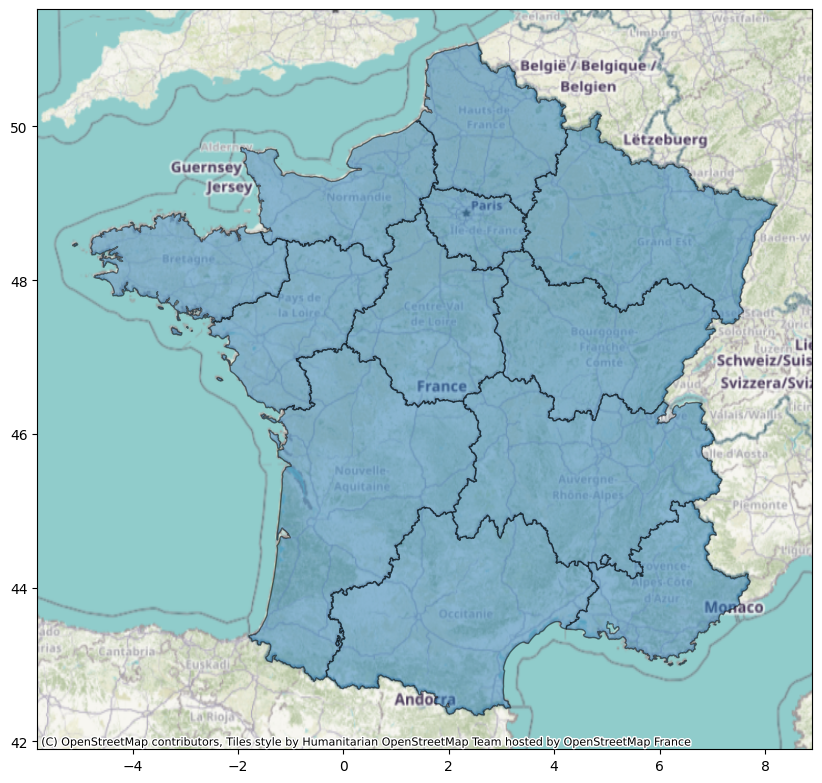

In [513]:
gdf["nom"].unique()
regions_exclure = ['Guadeloupe', 'Martinique', 'Guyane', 'La Réunion', 'Mayotte', 'Corse']
gdf = gdf[~gdf["nom"].isin(regions_exclure)]

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, alpha=0.5, edgecolor="k")
_ = ctx.add_basemap(ax, crs=gdf.crs.to_string())
plt.show()

**3.2. Mise en correspondance (Gare, Géoloc)**

In [514]:
loc_df.columns

Index(['Code plate-forme', 'Code gare', 'Code UIC',
       'Date fin validité plateforme', 'Intitulé plateforme', 'Code postal',
       'Code Commune', 'Commune', 'Code département', 'Département',
       'Longitude', 'Latitude', 'Segment DRG', 'Niveau de service', 'RG',
       'Intitulé gare', 'Intitulé fronton de gare', 'DTG', 'Région SNCF',
       'Unité gare', 'UT', 'Nbre plateformes', 'TVS', 'WGS 84'],
      dtype='object')

In [515]:
loc_df = loc_df[['Code UIC', 'Longitude', 'Latitude']]
loc_df.head()

,Code UIC,Longitude,Latitude
10,87784009.0,2.879779,42.696292
24,87765008.0,4.805281,43.941900
32,87761007.0,4.893273,44.928049
35,87757674.0,7.119498,43.585784
41,87757526.0,6.769083,43.423560


**3.2.2. Localiser les gares dans les régions (Gare_localisé + Contours régions)**

In [516]:
geometry = [Point(xy) for xy in zip(loc_df['Longitude'], loc_df['Latitude'])]
loc_df = gpd.GeoDataFrame(loc_df, geometry=geometry)

loc_df.head()

,Code UIC,Longitude,Latitude,geometry
10,87784009.0,2.879779,42.696292,POINT (2.87978 42.69629)
24,87765008.0,4.805281,43.941900,POINT (4.80528 43.9419)
32,87761007.0,4.893273,44.928049,POINT (4.89327 44.92805)
35,87757674.0,7.119498,43.585784,POINT (7.1195 43.58578)
41,87757526.0,6.769083,43.423560,POINT (6.76908 43.42356)


In [517]:
for e in loc_df:
    print(e, loc_df[e].nunique())

Code UIC 228
Longitude 227
Latitude 227
geometry 227


In [518]:
loc_df = loc_df.dropna()

In [519]:
loc_df["Code UIC"].dtype
loc_df["Code UIC"] = loc_df["Code UIC"].astype(int)

**3.3. Tester la cohérence des données**

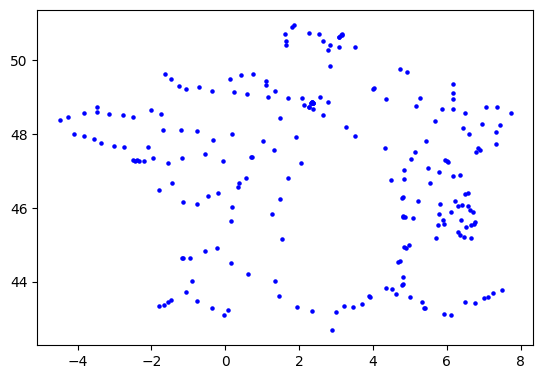

In [520]:
_ = loc_df.plot(marker='o', color='blue', markersize=5)
plt.show()

In [521]:
gdf_contours = gpd.GeoDataFrame(gdf, geometry="geometry")
gdf_points = gpd.GeoDataFrame(loc_df, geometry="geometry")

map_region_gare = gpd.sjoin(gdf_points, gdf_contours)

map_region_gare.head()

/tmp/ipython-input-1423662961.py:4: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




,Code UIC,Longitude,Latitude,geometry,index_right,nom
10,87784009,2.879779,42.696292,POINT (2.87978 42.69629),14,Occitanie
24,87765008,4.805281,43.941900,POINT (4.80528 43.9419),16,Provence-Alpes-Côte d'Azur
32,87761007,4.893273,44.928049,POINT (4.89327 44.92805),15,Auvergne-Rhône-Alpes
35,87757674,7.119498,43.585784,POINT (7.1195 43.58578),16,Provence-Alpes-Côte d'Azur
41,87757526,6.769083,43.423560,POINT (6.76908 43.42356),16,Provence-Alpes-Côte d'Azur


In [522]:
map_region_gare = map_region_gare.merge(gdf_contours, on='nom')
map_region_gare.columns

Index(['Code UIC', 'Longitude', 'Latitude', 'geometry_x', 'index_right', 'nom',
       'geometry_y'],
      dtype='object')

In [523]:
map_region_gare = map_region_gare[['Code UIC', 'geometry_x', 'nom', 'geometry_y']]
map_region_gare.isna().sum()

,0
Code UIC,0
geometry_x,0
nom,0
geometry_y,0


In [524]:
for e in map_region_gare:
    print(map_region_gare[e].nunique())

228
227
12
12


/usr/local/lib/python3.12/dist-packages/pyproj/crs/crs.py:143: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/tmp/ipython-input-1017572405.py:16: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



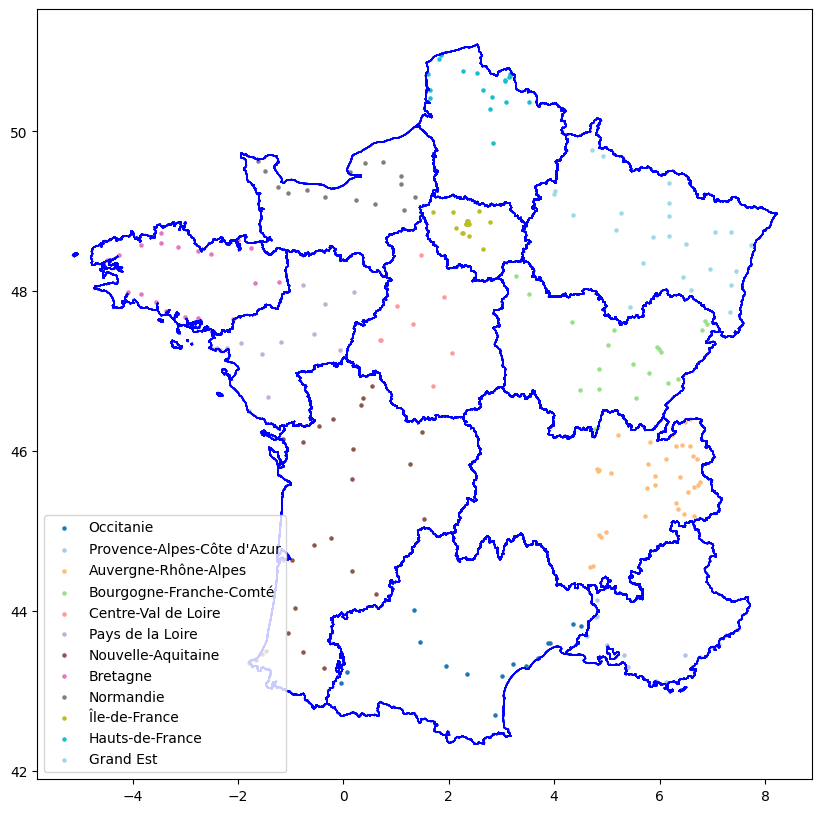

In [525]:
points_geometry = [shape(geojson) for geojson in map_region_gare["geometry_x"]]
points_gdf = gpd.GeoDataFrame(map_region_gare, geometry=points_geometry)

contours_geometry = [shape(geojson) for geojson in map_region_gare["geometry_y"]]
contours_gdf = gpd.GeoDataFrame(map_region_gare, geometry=contours_geometry)

points_gdf.crs = {"init": "epsg:4326"}
contours_gdf.crs = {"init": "epsg:4326"}

fig, ax = plt.subplots(figsize=(10, 10))

contours_gdf.boundary.plot(ax=ax, color="blue", linewidth=1)

regions = points_gdf["nom"]
unique_regions = regions.unique()
colors = plt.cm.get_cmap("tab20", len(unique_regions))

for i, region in enumerate(unique_regions):
    region_points = points_gdf[points_gdf["nom"] == region]
    region_points.plot(ax=ax, marker="o", color=colors(i), markersize=5, label=f"{region}")

plt.legend()
plt.show()

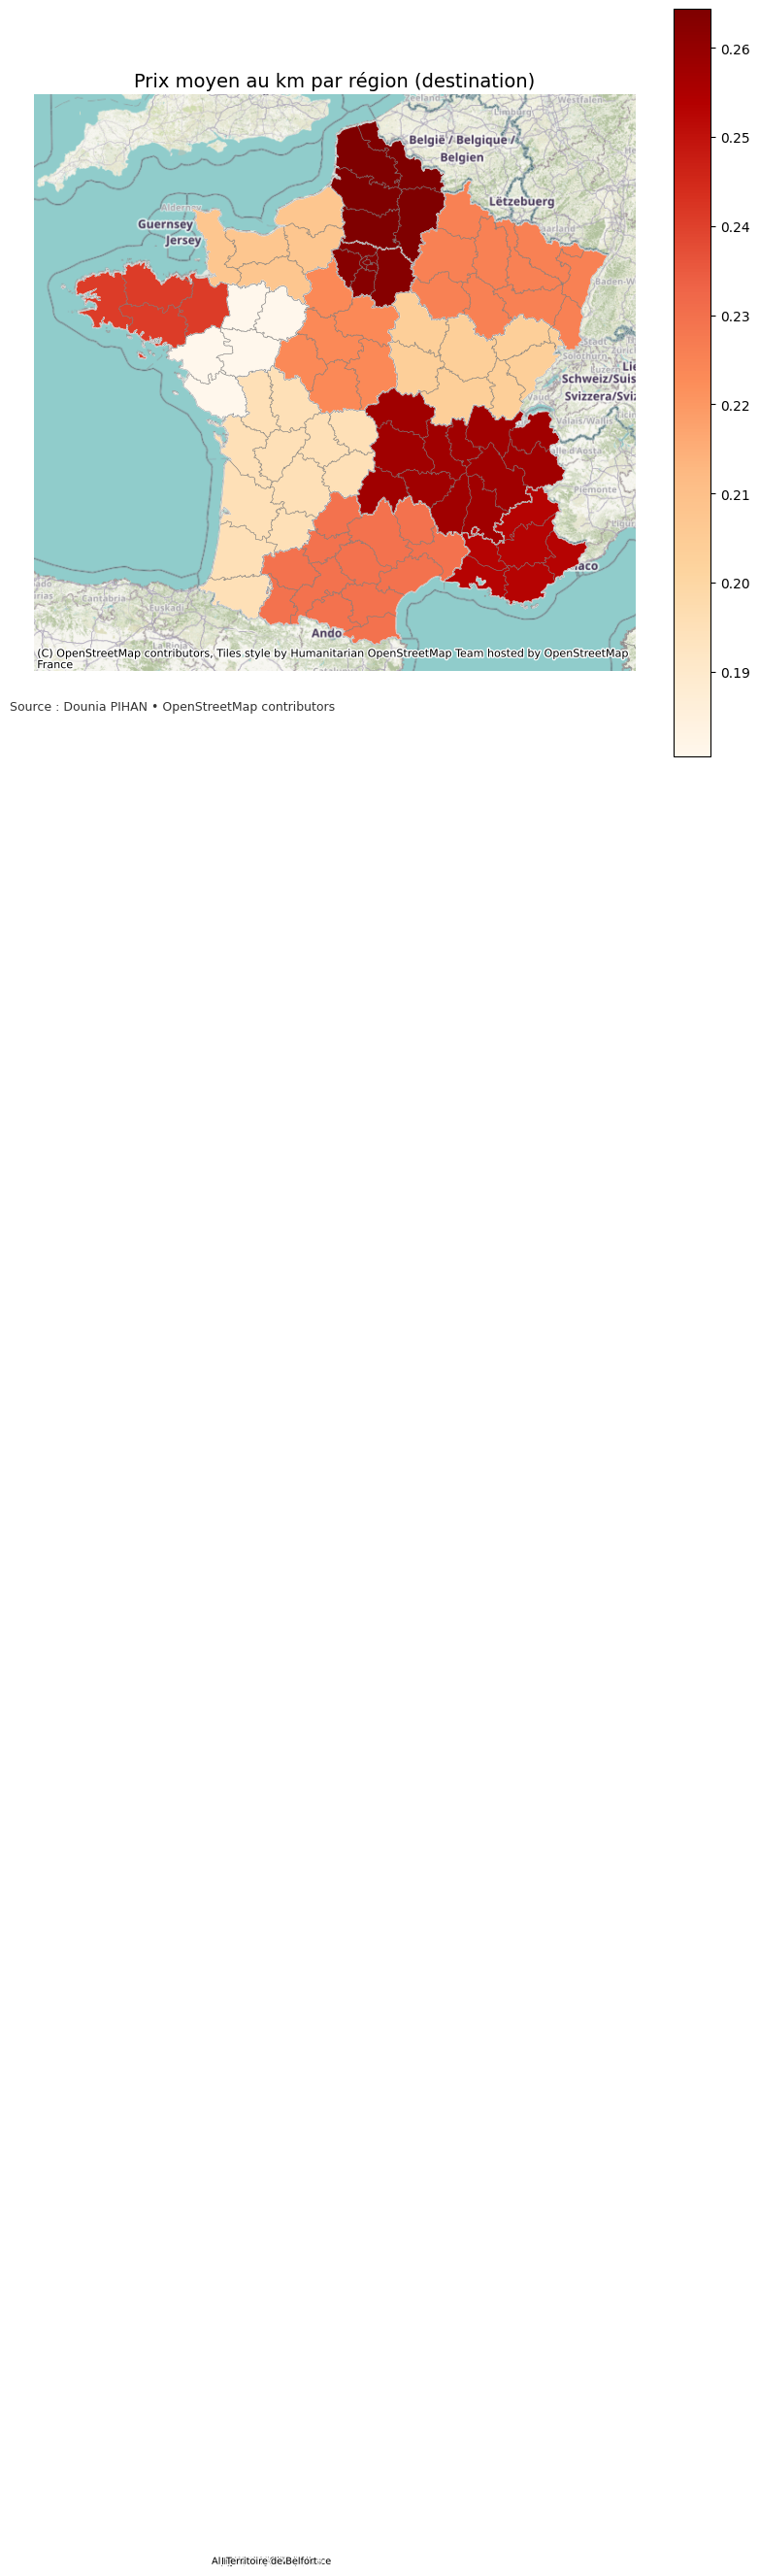

In [526]:
try:
    import contextily as ctx
    USE_BASEMAP = True
except Exception:
    USE_BASEMAP = False

gdf_regions = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/regions.geojson")[["nom", "geometry"]]
loc_df = pd.read_csv("referentiel-gares-voyageurs.csv", sep=";")

regions_exclure = ['Guadeloupe', 'Martinique', 'Guyane', 'La Réunion', 'Mayotte', 'Corse']
gdf_regions = gdf_regions[~gdf_regions["nom"].isin(regions_exclure)].copy()

loc_small = loc_df[['Code UIC', 'Longitude', 'Latitude']].dropna().copy()
loc_small['Code UIC'] = pd.to_numeric(loc_small['Code UIC'], errors='coerce').dropna().astype(int)
gdf_points = gpd.GeoDataFrame(
    loc_small,
    geometry=gpd.points_from_xy(loc_small['Longitude'], loc_small['Latitude']),
    crs="EPSG:4326"
)

if gdf_regions.crs is None:
    gdf_regions.set_crs("EPSG:4326", inplace=True)

points_in_regions = gpd.sjoin(
    gdf_points,
    gdf_regions[['nom', 'geometry']],
    how='left',
    predicate='within'
)[['Code UIC', 'nom', 'geometry']]

base_df2 = base_df.copy()
base_df2['Gare destination - code UIC'] = pd.to_numeric(
    base_df2['Gare destination - code UIC'], errors='coerce'
).astype('Int64')

prix_par_point = base_df2.merge(
    points_in_regions[['Code UIC', 'nom']],
    left_on='Gare destination - code UIC',
    right_on='Code UIC',
    how='left'
)

prix_region = (
    prix_par_point
      .dropna(subset=['Prix par km'])
      .groupby('nom', as_index=False)
      .agg(
          prix_km_moy=('Prix par km', 'mean'),
          prix_km_med=('Prix par km', 'median'),
          n_obs=('Prix par km', 'size')
      )
)

carte_regions = gdf_regions.merge(prix_region, on='nom', how='left')

gdf_dept = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/departements.geojson")[['nom', 'code', 'geometry']]
gdf_dept = gdf_dept[~gdf_dept['nom'].isin(regions_exclure)].copy()
gdf_dept['label_point'] = gdf_dept.representative_point()

if USE_BASEMAP:
    carte_plot = carte_regions.to_crs(epsg=3857)
    dept_plot  = gdf_dept.to_crs(epsg=3857)
else:
    carte_plot = carte_regions.to_crs(epsg=4326)
    dept_plot  = gdf_dept.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

carte_plot.plot(
    ax=ax,
    column='prix_km_moy',
    cmap='OrRd',
    legend=True,
    edgecolor='white',
    linewidth=0.8,
    missing_kwds={'color':'#f0f0f0', 'edgecolor':'white', 'hatch':'///', 'label':'Données manquantes'}
)

if USE_BASEMAP:
    ctx.add_basemap(ax, crs=carte_plot.crs)

dept_plot.boundary.plot(ax=ax, linewidth=0.4, edgecolor='gray', alpha=0.7)

for _, r in dept_plot.iterrows():
    x, y = r['label_point'].x, r['label_point'].y
    ax.text(
        x, y, r['nom'],
        fontsize=7, ha='center', va='center', color='black',
        path_effects=[pe.withStroke(linewidth=2, foreground='white', alpha=0.9)]
    )



pos = ax.get_position()
fig.text(
    (pos.x0 + pos.x1)/2, pos.y0 - 0.03,
    'Source : Dounia PIHAN • OpenStreetMap contributors',
    ha = 'right', va = 'top',
    fontsize=9, alpha=0.8
)

ax.set_title("Prix moyen au km par région (destination)", fontsize=14)
ax.axis('off')
plt.show()

In [527]:
fig.text(0.0, -0.02, "Source : PIHAN Dounia", fontsize=9, alpha=0.7)

Text(0.0, -0.02, 'Source : PIHAN Dounia')

In [528]:
print("\nTop 10 régions les plus chères au km :")
print(prix_region.sort_values('prix_km_moy', ascending=False).head(10))

print("\nTop 10 régions les moins chères au km :")
print(prix_region.sort_values('prix_km_moy', ascending=True).head(10))


Top 10 régions les plus chères au km :
                           nom  prix_km_moy  prix_km_med  n_obs
5              Hauts-de-France     0.264374     0.242468   1236
11               Île-de-France     0.262761     0.234983   1878
0         Auvergne-Rhône-Alpes     0.257701     0.201367   3360
10  Provence-Alpes-Côte d'Azur     0.253095     0.164039   1383
2                     Bretagne     0.240863     0.148525   1529
8                    Occitanie     0.229453     0.150963   1555
4                    Grand Est     0.225481     0.147256    993
3          Centre-Val de Loire     0.223566     0.173536    469
6                    Normandie     0.207363     0.119230    324
1      Bourgogne-Franche-Comté     0.203533     0.154864   1162

Top 10 régions les moins chères au km :
                           nom  prix_km_moy  prix_km_med  n_obs
9             Pays de la Loire     0.180481     0.087966    632
7           Nouvelle-Aquitaine     0.195497     0.127166   1053
1      Bourgogne-Franch

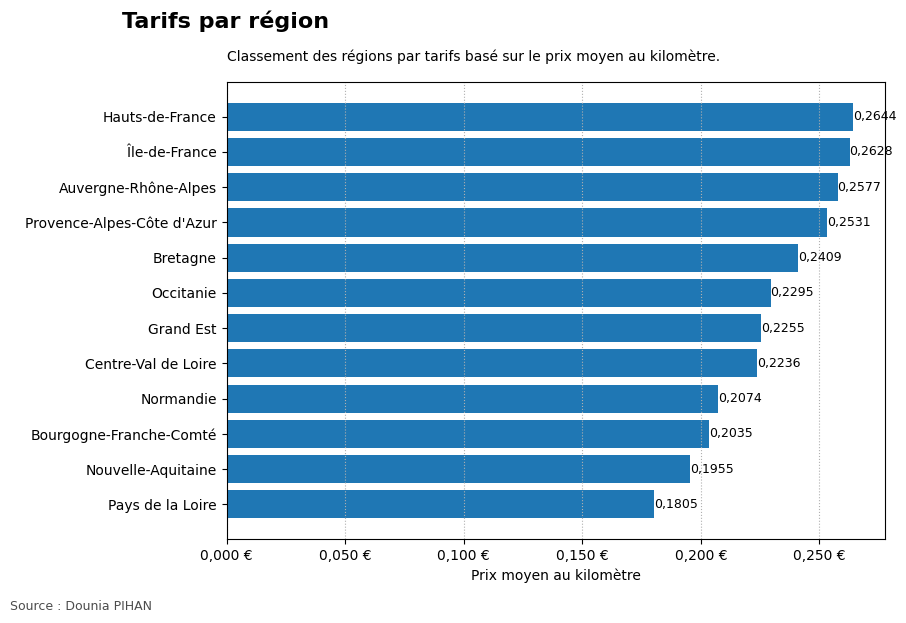

In [529]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def euro_km_fmt(x, pos):
    """Format 0.0418 -> '0,04 €' """
    s = f"{x:.3f}".replace('.', ',')
    return f"{s} €"

df_sorted = prix_region.sort_values('prix_km_moy', ascending=False).copy()

fig, ax = plt.subplots(figsize=(9, 6))

bars = ax.barh(df_sorted['nom'], df_sorted['prix_km_moy'], color="#1f77b4")

for bar, v in zip(bars, df_sorted['prix_km_moy']):
    ax.text(bar.get_width(),
            bar.get_y() + bar.get_height()/2,
            f"{v:.4f}".replace('.', ','),
            va='center', ha='left', fontsize=9, color='black')

plt.suptitle("Tarifs par région", fontsize=16, weight='bold', x=0.125, ha='left')
ax.set_title("Classement des régions par tarifs basé sur le prix moyen au kilomètre.",
             fontsize=10, loc='left', pad=15)

ax.set_xlabel("Prix moyen au kilomètre")
ax.xaxis.set_major_formatter(FuncFormatter(euro_km_fmt))
ax.grid(axis='x', linestyle=':', linewidth=0.8)
ax.set_ylabel("")
ax.invert_yaxis()

fig.text(0.0, -0.02, "Source : Dounia PIHAN", fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()